# Выбор локации для скважины

Представим, что мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import seaborn as sns

In [2]:
df0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
display(df0.head())
display(df1.head())
display(df2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
display(df0.shape)
display(df1.shape)
display(df2.shape)

(100000, 5)

(100000, 5)

(100000, 5)

In [5]:
display(df0.info())
display(df1.info())
display(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [6]:
display(df0.describe())
display(df1.describe())
display(df2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
display(df0.duplicated().sum())
display(df1.duplicated().sum())
display(df2.duplicated().sum())

0

0

0

Дубликаты в данных не обнаружены

In [8]:
display(df0.isnull().sum())
display(df1.isnull().sum())
display(df2.isnull().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

В данных пропусков нет

In [9]:
df0['id'].duplicated().sum()

10

In [10]:
df1['id'].duplicated().sum()

4

In [11]:
df2['id'].duplicated().sum()

4

In [12]:
df0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


"f2" и "product" имеют среднюю 0.483663 (если округлить) корреляцию,

"f0" и "f1" имеют слабую -0.440723, но ближе к средней корреляцию

In [13]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


"f0" и "f1" имеют очень слабую 0.182287 корреляцию

"f2" и "product" имеют очень высокую 0.999397 корреляцию

In [14]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


"f2" и "product" имеют слабую 0.445871 корреляцию (но ближе к средней).

У остальных корреляция близка к нулю.

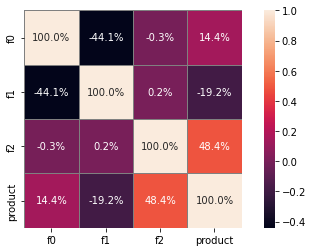

In [15]:
plt.rcParams["figure.figsize"] = (8, 4)
sns.heatmap(df0.corr(), annot = True, square=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

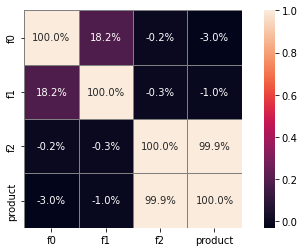

In [16]:
plt.rcParams["figure.figsize"] = (8, 4)
sns.heatmap(df1.corr(), annot = True, square=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

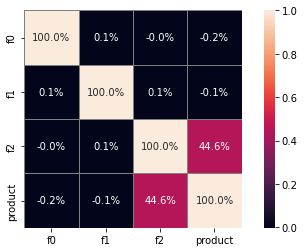

In [17]:
plt.rcParams["figure.figsize"] = (8, 4)
sns.heatmap(df2.corr(), annot = True, square=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

У всех датасетов мы увидели общий паттерн - высокую взаимосвязь между f2 и product.

## Обучение и проверка модели

In [18]:
#Разбиваем данные на обучающую и валидационную выборку

df0_train, df0_valid = train_test_split(df0, test_size=0.25, random_state=12345)
df1_train, df1_valid = train_test_split(df1, test_size=0.25, random_state=12345)
df2_train, df2_valid = train_test_split(df2, test_size=0.25, random_state=12345)


features_train1 = df0_train.drop(['id', 'product'], axis=1)
target_train1 = df0_train['product']
features_valid1 = df0_valid.drop(['id', 'product'], axis=1)
target_valid1 = df0_valid['product']

features_train2 = df1_train.drop(['id', 'product'], axis=1)
target_train2 = df1_train['product']
features_valid2 = df1_valid.drop(['id', 'product'], axis=1)
target_valid2 = df1_valid['product']

features_train3 = df2_train.drop(['id', 'product'], axis=1)
target_train3 = df2_train['product']
features_valid3 = df2_valid.drop(['id', 'product'], axis=1)
target_valid3 = df2_valid['product']

print('Первая обучающая выборка:',features_train1.shape)
print(target_train1.shape)
print('Первая валидационная выборка:',features_valid1.shape)
print(target_valid1.shape)
print()
print('Вторая обучающая выборка:',features_train2.shape)
print(target_train2.shape)
print('Вторая валидационная выборка:',features_valid2.shape)
print(target_valid2.shape)
print()
print('Третья обучающая выборка:',features_train3.shape)
print(target_train3.shape)
print('Третья валидационная выборка:',features_valid3.shape)
print(target_valid3.shape)

Первая обучающая выборка: (75000, 3)
(75000,)
Первая валидационная выборка: (25000, 3)
(25000,)

Вторая обучающая выборка: (75000, 3)
(75000,)
Вторая валидационная выборка: (25000, 3)
(25000,)

Третья обучающая выборка: (75000, 3)
(75000,)
Третья валидационная выборка: (25000, 3)
(25000,)


Построение модели по трем регионам с месторождениями, с выведением средних данных и RMSE

In [35]:
#1

model = LinearRegression()
model.fit(features_train1,target_train1) # обучение модели на тренировочной выборке
predictions_valid = model.predict(features_valid1) # предсказания модели на валидационной выборке
df0_pred_mean=predictions_valid.mean()
result = mean_squared_error(target_valid1,predictions_valid)**0.5
df0_predictions_valid = model.predict(features_valid1)

print("Средний предсказанный запас предсказанного сырья в месторождении", df0_pred_mean)
print("Средний фактический запас сырья в месторождении", target_valid1.mean())
print("RMSE модели линейной регрессии на валидационной выборке:", result)

Средний предсказанный запас предсказанного сырья в месторождении 92.59256778438035
Средний фактический запас сырья в месторождении 92.07859674082941
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813


In [36]:
#2

model = LinearRegression()
model.fit(features_train2,target_train2)
predictions_valid = model.predict(features_valid2)
df1_pred_mean=predictions_valid.mean()
result = mean_squared_error(target_valid2,predictions_valid)**0.5
df1_predictions_valid = model.predict(features_valid2)

print("Средний предсказанный запас предсказанного сырья в месторождении", df1_pred_mean)
print("Средний фактический запас сырья в месторождении", target_valid2.mean())
print("RMSE модели линейной регрессии на валидационной выборке:", result)

Средний предсказанный запас предсказанного сырья в месторождении 68.728546895446
Средний фактический запас сырья в месторождении 68.72313602437494
RMSE модели линейной регрессии на валидационной выборке: 0.8930992867756167


In [22]:
#3

model = LinearRegression()
model.fit(features_train3,target_train3)
predictions_valid = model.predict(features_valid3)
df2_pred_mean=predictions_valid.mean()
result = mean_squared_error(target_valid3,predictions_valid)**0.5
df2_predictions_valid = model.predict(features_valid3)

print("Средний предсказанный запас предсказанного сырья в месторождении", df2_pred_mean)
print("Средний фактический запас сырья в месторождении", target_valid3.mean())
print("RMSE модели линейной регрессии на валидационной выборке:", result)

Средний предсказанный запас предсказанного сырья в месторождении 94.96504596800489
Средний фактический запас сырья в месторождении 94.88423280885489
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434


**Вывод**

Средний запас предсказанного сырья практически соответствует средним значениям запасов первоначальных данных;
По показателю RMSE, второй регион считается самым прибыльным, но при этом отстает по запасам сырья двух других регионов.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [37]:
# бюджет на разработку скважин в регионе 10 000 000 000

BUDG = 10_000_000_000

In [38]:
# Рыночная цена за один баррель 450 руб., т.к. в данных объем указан в тысячах, умножим на 1000

BAR = 450_000

In [39]:
# При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

SKVAJ = 200

In [26]:
# Расчитаем цену одной скважины

PRICE_SKVAJ = BUDG / SKVAJ

print(PRICE_SKVAJ)

50000000.0


In [27]:
# Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

COUNT_BAR = BUDG / SKVAJ / BAR

print(COUNT_BAR)

111.11111111111111


In [28]:
# Сравним полученный объём сырья со средним запасом в каждом регионе.

df1_mean = target_valid1.mean()
df2_mean = target_valid2.mean()
df3_mean = target_valid3.mean()

print(df1_mean)
print(df2_mean)
print(df3_mean)

92.07859674082941
68.72313602437494
94.88423280885489


**Вывод**

Для получения прибыли, необходимо выбрать скважину с объемом выработки 111.11 тыс.баррелей;
Средние запасы каждого из регионов меньше необходимого запаса для безубыточной разработки, по предсказаниям в среднем такого объема нет ни в одном регионе.

## Расчёт прибыли и рисков 

In [29]:
# Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:


def profit(target, predictions, count):
    profit=0
    probs_sorted = predictions.sort_values(ascending=False).head(200)
    selected = target[probs_sorted.index][:count] 
    for top in selected:
        profit+=(top-COUNT_BAR)*450000
    return profit

In [30]:
df0_valid['product_pred']=df0_predictions_valid

profit0=profit(df0_valid['product'], df0_valid['product_pred'],200)
print("Прибыльность по первому региону (200 лучших скважин):", round(profit0/1000000), "млн.")

Прибыльность по первому региону (200 лучших скважин): 3321 млн.


In [31]:
df1_valid['product_pred']=df1_predictions_valid

profit1=profit(df1_valid['product'], df1_valid['product_pred'],200)
print("Прибыльность по второму региону (200 лучших скважин):", round(profit1/1000000), "млн.")

Прибыльность по второму региону (200 лучших скважин): 2415 млн.


In [32]:
df2_valid['product_pred']=df2_predictions_valid

profit2=profit(df2_valid['product'], df2_valid['product_pred'],200)
print("Прибыльность по третьему региону (200 лучших скважин):", round(profit2/1000000), "млн.")

Прибыльность по третьему региону (200 лучших скважин): 2710 млн.


**Вывод**

По валидационным данным - максимальная прибыль у первого региона

## Подсчет рисков и прибыли для каждого региона: 

In [33]:
# Воспользуемся методом Bootstrap, создадим функцию для подсчета

def bootstrap (target, predictions):
    state = np.random.RandomState(12345)
    values = []
    counter=0
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        preds_subsample = predictions[target_subsample.index]
        target_subsample = target_subsample.reset_index(drop=True)
        preds_subsample = preds_subsample.reset_index(drop=True)
        
        values.append(profit(target_subsample, preds_subsample, 500))
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    loss = values[values<0]
    
    print("Вероятность убытков: {:.2%}".format(loss.count()/len(values)))
    print("Среднее значение бутстрепа", (values.mean())/1000000, "млн.")
    print("Верхняя граница доверительного интервала", higher)
    print("Нижняя граница доверительного интервала", lower)
    print()
print("Для первого региона")
bootstrap(df0_valid['product'], df0_valid['product_pred'])
print()
print("Для второго региона")
bootstrap(df1_valid['product'], df1_valid['product_pred'])
print()
print("Для третьего региона")
bootstrap(df2_valid['product'], df2_valid['product_pred'])


Для первого региона
Вероятность убытков: 6.90%
Среднее значение бутстрепа 396.1649848023705 млн.
Верхняя граница доверительного интервала 909766941.5534233
Нижняя граница доверительного интервала -111215545.89049569


Для второго региона
Вероятность убытков: 1.50%
Среднее значение бутстрепа 456.04510578666515 млн.
Верхняя граница доверительного интервала 852289453.8660345
Нижняя граница доверительного интервала 33820509.398989625


Для третьего региона
Вероятность убытков: 7.60%
Среднее значение бутстрепа 404.4038665683573 млн.
Верхняя граница доверительного интервала 950359574.9238007
Нижняя граница доверительного интервала -163350413.39560026



In [34]:
a = pd.Series([2, 2, 2, 5, 6, 3], index = [1, 1, 1, 2, 2, 2])
print(a[1])
print(a[a.index])
a = a.reset_index(drop = True)
print(a[3], "mm")
print(a[a.index])

1    2
1    2
1    2
dtype: int64
1    2
1    2
1    2
1    2
1    2
1    2
1    2
1    2
1    2
2    5
2    6
2    3
2    5
2    6
2    3
2    5
2    6
2    3
dtype: int64
5 mm
0    2
1    2
2    2
3    5
4    6
5    3
dtype: int64


***Вывод***

Исходя из проведенного анализа данных, построения модели и проверки методом Bootstrap по трем регионам, можно сделать вывод - больше всего для новых скважин подходит второй регион, т.к. он имеет меньшую вероятность убытков 1.5% и лучший показатель RMSE 0.89